In [63]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as st
# import scipy.linalg as linalg
# import scipy.optimize as so
# import statsmodels.api as sm
# import statsmodels.graphics.tsaplots as sm 
import random
# import time
import math


# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

# from numpy import matlib
# from scipy import io
# from scipy.special import erf
# from scipy.fftpack import fft, ifft
# from scipy import interpolate as intrp
# from matplotlib import rc
# from tools import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Point 1 - Basic ABC rejection algorithm

In [3]:
# set problem parameters
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances
N = 500  # max number of accepted samples

def discrepancy_metric(x, sample_mean=0):
    # rho(S(D*),S(D)) = abs(mean(x*) - mean(x)), we assume that mean(x)=0 (sample mean)
    return abs(np.mean(x) - sample_mean)

def true_mixture_distribution(x, M, a, var, var_1, sample_mean=0):
    alfa = 1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )
    pdf_1 = alfa * st.norm.pdf(x=x, loc = var/(var+var_1/M)*sample_mean, scale = var_1/(M+var_1/var))
    pdf_2 = (1-alfa) * st.norm.pdf(x=x, loc = var/(var+var_1/M)*(sample_mean-a), scale = var_1/(M+var_1/var))
    # f = alfa * st.norm(loc = var/(var+var_1/M)*sample_mean, scale = var_1/(M+var_1/var)) + (1-alfa) * st.norm(loc = var/(var+var_1/M)*(sample_mean-a), scale = var_1/(M+var_1/var))
    f = pdf_1 + pdf_2
    return f

def generate_data(M, theta, var, var_1, a):
    D = np.zeros(M)
    # do stuff ...
    return D

def basic_abc(N, M, eps, var, var_1, a):
    theta = np.zeros(N)
    pi_rv = st.norm(loc=0, scale=var)
    rejection_count = 0
    entered = 0
    n1_count = 0  #DEBUG
    n2_count = 0  #DEBUG
    i = 0
    while i < N:
        # sample candidate parameters from the prior distribution pi = N(0,var)
        theta_star = pi_rv.rvs()
    
        # generate data from the underlying model given theta_star
        # D observed data, is an iid sample drawn with prob=0.5 from N(theta,var_1), o/w from N(theta+a,var_1)
        N1_rv = st.norm(loc=theta_star, scale=var_1)
        N2_rv = st.norm(loc=theta_star + a, scale=var_1)
        D = np.zeros(M)
        for j in range(M):
            if st.uniform.rvs(0,1) < 0.5:
                D[j] = N1_rv.rvs()
                n1_count = n1_count + 1
            else:
                D[j] = N2_rv.rvs()
                n2_count = n1_count + 1
        
        if discrepancy_metric(D) < eps:
            theta[i] = theta_star
            entered = entered + 1
        else:
            rejection_count = rejection_count + 1
            i = i - 1  # repeat the iteration
        i = i + 1
    
    # print(entered)
    # print(rejection_count)
    # print(n1_count, n2_count)
    print('acceptance rate:', entered/(entered+rejection_count))
    return theta

acceptance rate: 0.19849146486701072
acceptance rate: 0.06623393826996954
acceptance rate: 0.02554017469479491
acceptance rate: 0.006296277640658842


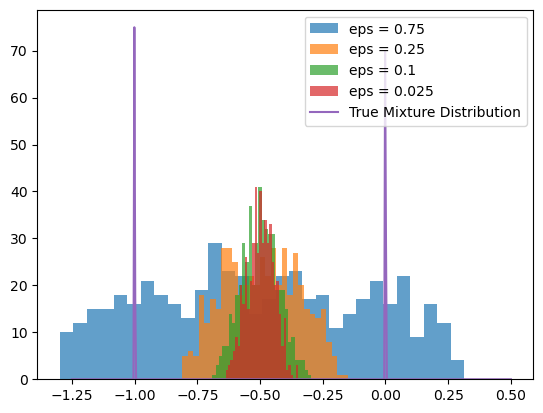

In [4]:
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)
for e in eps:
    theta = basic_abc(N, M, e, var, var_1, a)
    label = 'eps = %s'%(e)
    plt.hist(theta, bins=30, alpha=0.7, label=label)
plt.plot(x_values, f, label='True Mixture Distribution')
plt.legend()
plt.show()

acceptance rate: 0.06895600606812853


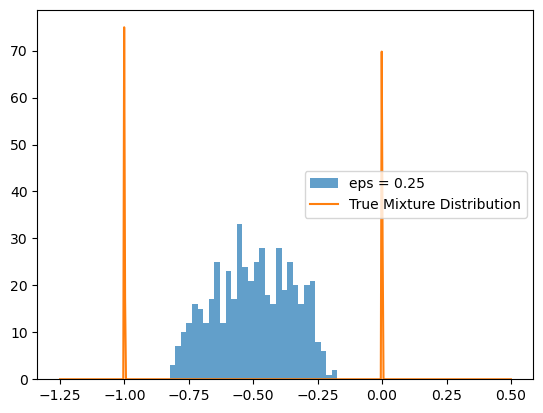

In [6]:
### DEBUG
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)
for e in [0.25]:
    theta = basic_abc(N, M, e, var, var_1, a)
    label = 'eps = %s'%(e)
    plt.hist(theta, bins=30, alpha=0.7, label=label)
plt.plot(x_values, f, label='True Mixture Distribution')
plt.legend()
plt.show()

# Point 3 - ABC-MCMC algorithm

## ver. 1.0

In [16]:
# set problem parameters
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances

def abc_mcmc(N_max, N_eff, M, eps, nu_squared, var, var_1, a):
    theta = np.zeros(N_max+1)
    pi_rv = st.norm(loc=0, scale=nu_squared)  # prior ?
    acceptance_count = 0
    rejection_count = 0
    entered = 0
    i = 0
    while (acceptance_count < N_eff) & (i < N_max):
        # sample candidate parameters from a proposal transition density q(theta_i, )
        # random walk proposal q(theta, ) = N(theta,nu_squared)
        q_i = st.norm(loc=theta[i], scale=nu_squared)
        theta_star = q_i.rvs()
    
        # generate data from the underlying model given theta_star
        # generate_data function: TODO
        N1_rv = st.norm(loc=theta_star, scale=var_1)
        N2_rv = st.norm(loc=theta_star + a, scale=var_1)
        D = np.zeros(M)
        for j in range(M):
            if st.uniform.rvs(0,1) < 0.5:
                D[j] = N1_rv.rvs()
                # n1_count = n1_count + 1
            else:
                D[j] = N2_rv.rvs()
                # n2_count = n1_count + 1
    
        if discrepancy_metric(D) < eps:
            q_star = st.norm(loc=theta_star, scale=nu_squared)
            comp = pi_rv.pdf(theta_star)*q_star.pdf(theta[i])/( pi_rv.pdf(theta[i])*q_i.pdf(theta_star) )

            entered = entered + 1
            if st.uniform.rvs() < comp:
                theta[i+1] = theta_star
                acceptance_count = acceptance_count + 1 
            else:
                theta[i+1] = theta[i]
                rejection_count = rejection_count + 1
        else:
            theta[i+1] = theta[i]
            rejection_count = rejection_count + 1
        i = i + 1
    
    print(acceptance_count, entered, rejection_count, i) ## DEBUG
    if acceptance_count == 500:
        print('effective sample size achieved')
    print('acceptance rate:', acceptance_count/(acceptance_count+rejection_count))
    return theta

500 697 225 725
effective sample size achieved
acceptance rate: 0.6896551724137931
500 1429 3730 4230
effective sample size achieved
acceptance rate: 0.1182033096926714
0 0 5000 5000
acceptance rate: 0.0
0 1 5000 5000
acceptance rate: 0.0


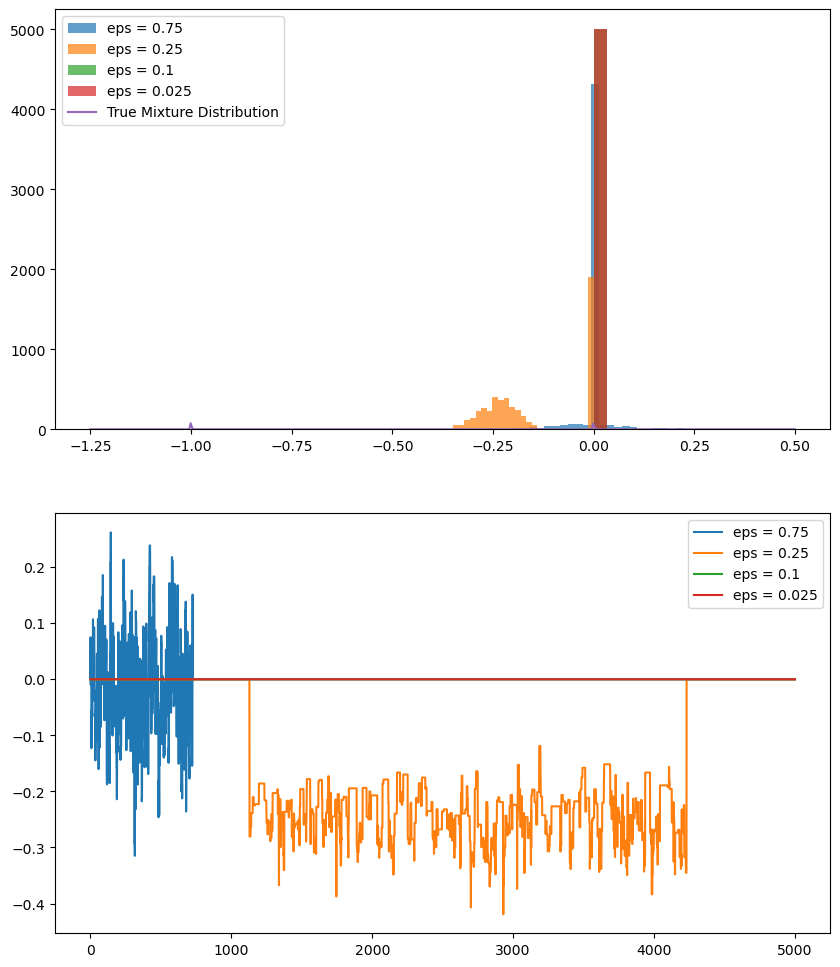

In [17]:
N_max = 5000  # max number of accepted samples ### TEMP
N_eff = 500  # effective size
nu_squared = var_1  ### TEMP

x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

fig, axs = plt.subplots(2, figsize=(10,12))
for e in eps:
    theta = abc_mcmc(N_max, N_eff, M, e, nu_squared, var, var_1, a)
    label = 'eps = %s'%(e)
    axs[0].hist(theta, bins=30, alpha=0.7, label=label)
    axs[1].plot(theta, label=label)
axs[0].plot(x_values, f, label='True Mixture Distribution')
axs[0].legend()
axs[1].legend()
plt.show()

## ver. 1.1 - effective sample size

662 2007 4338 5000
acceptance rate: 0.1324


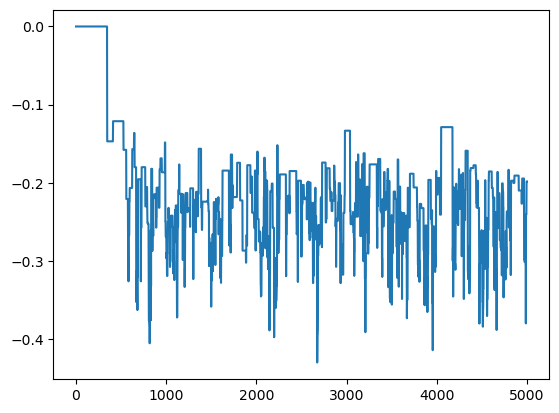

In [24]:
### Update effective sample size: ESS = N c(0)/sigma^2
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances

# N_max = 5000  # max number of accepted samples
N_eff = 500  # effective size
nu_squared = var_1  # TEMP

def abc_mcmc(N_max, M, eps, nu_squared, var, var_1, a):
    theta = np.zeros(N_max+1)
    pi_rv = st.norm(loc=0, scale=nu_squared)  # prior ?
    acceptance_count = 0
    rejection_count = 0
    entered = 0
    i = 0
    while i < N_max:
        # sample candidate parameters from a proposal transition density q(theta_i, )
        # random walk proposal q(theta, ) = N(theta,nu_squared)
        q_i = st.norm(loc=theta[i], scale=nu_squared)
        theta_star = q_i.rvs()
    
        # generate data from the underlying model given theta_star
        # generate_data function: TODO
        N1_rv = st.norm(loc=theta_star, scale=var_1)
        N2_rv = st.norm(loc=theta_star + a, scale=var_1)
        D = np.zeros(M)
        for j in range(M):
            if st.uniform.rvs(0,1) < 0.5:
                D[j] = N1_rv.rvs()
                # n1_count = n1_count + 1
            else:
                D[j] = N2_rv.rvs()
                # n2_count = n1_count + 1
    
        if discrepancy_metric(D) < eps:
            q_star = st.norm(loc=theta_star, scale=nu_squared)
            comp = pi_rv.pdf(theta_star)*q_star.pdf(theta[i])/( pi_rv.pdf(theta[i])*q_i.pdf(theta_star) )
            
            entered = entered + 1
            if st.uniform.rvs() < comp:
                theta[i+1] = theta_star
                acceptance_count = acceptance_count + 1 
            else:
                theta[i+1] = theta[i]
                rejection_count = rejection_count + 1
        else:
            theta[i+1] = theta[i]
            rejection_count = rejection_count + 1
        i = i + 1
    
    print(acceptance_count, entered, rejection_count, i) ## DEBUG
    #if acceptance_count == 500:
    #    print('effective sample size achieved')
    print('acceptance rate:', acceptance_count/(acceptance_count+rejection_count))
    return theta

# estimate the asymptotic variance (covariance method)
N_max = 5000  # 10*N_eff
e = 0.25
c_hat = []
theta = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)
plt.plot(theta, label='eps=%s'%(e))

In [51]:
### update (cont.)
b = 1000  # burn-in
mu_hat = theta[b:].mean()
k = 0
while k < N_max-1:
    c_hat.append(1/(N_max-k-1)*np.multiply(theta[b:N_max-k+1] - mu_hat, theta[b+k:] - mu_hat).sum())
    k = k + 1

In [56]:
### update (cont.)
for k, _ in enumerate(c_hat):
    if c_hat[2*k] - c_hat[2*k+1] < 0:
        M_eff = 2*k
        break
print(M_eff)

50


In [59]:
var_M_hat = c_hat[0] + 2*sum(c_hat[1:M_eff+1])
var_hat = c_hat[0] + 2*sum(c_hat[1:])

print('sigma^2^hat =', var_hat)
print('sigma^2^hat_M =', var_M_hat)

sigma^2^hat = -0.006051729790505925
sigma^2^hat_M = 0.0691912820427502


In [64]:
N_max = math.ceil(N_eff*var_M_hat/c_hat[0])
print('N_max =', N_max)

N_max = 16535


11518 15797 5017 16535
acceptance rate: 0.6965830057453886
2247 6874 14288 16535
acceptance rate: 0.1358935591170245
0 1 16535 16535
acceptance rate: 0.0
0 0 16535 16535
acceptance rate: 0.0


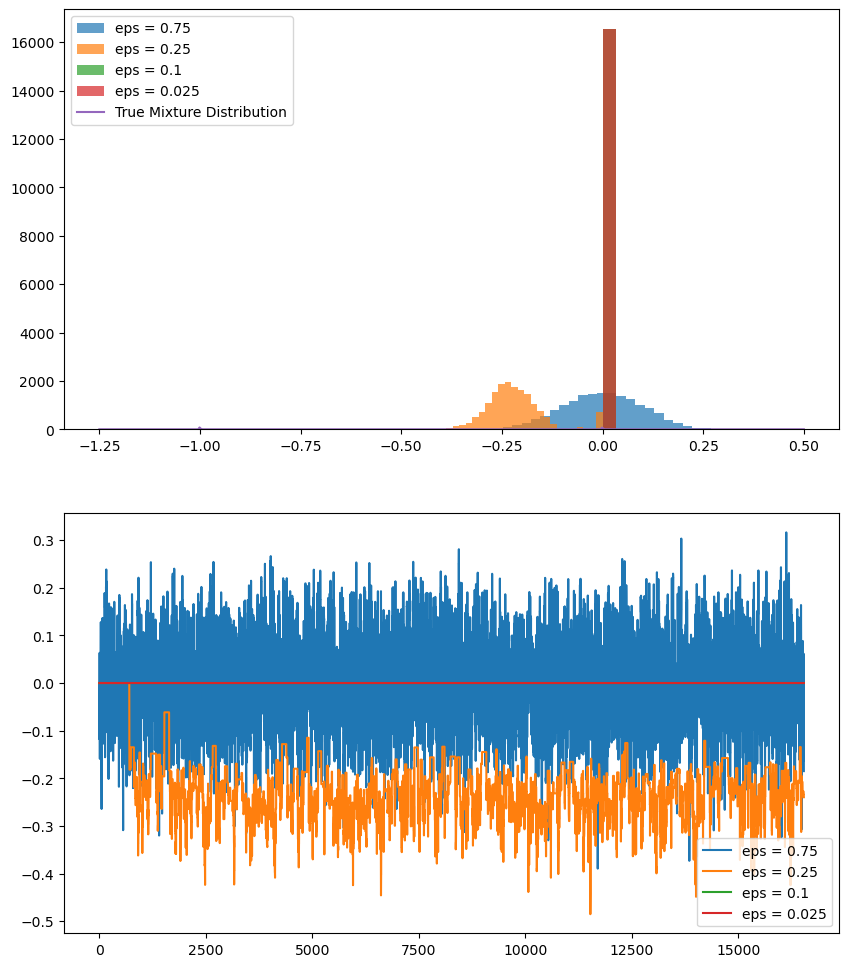

In [65]:
### update (cont.)
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

fig, axs = plt.subplots(2, figsize=(10,12))
for e in eps:
    theta = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)
    label = 'eps = %s'%(e)
    axs[0].hist(theta, bins=30, alpha=0.7, label=label)
    axs[1].plot(theta, label=label)
axs[0].plot(x_values, f, label='True Mixture Distribution')
axs[0].legend()
axs[1].legend()
plt.show()

# DEBUG

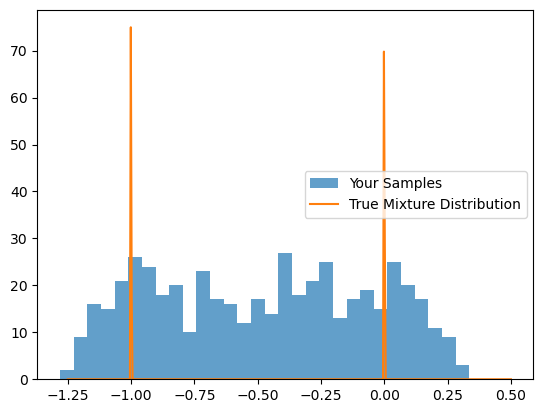

In [209]:
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

plt.hist(theta, bins=30, alpha=0.7, label='Your Samples')
plt.plot(x_values, f, label='True Mixture Distribution')
plt.legend()
plt.show()

In [208]:
f.sum()

84.68889923237376

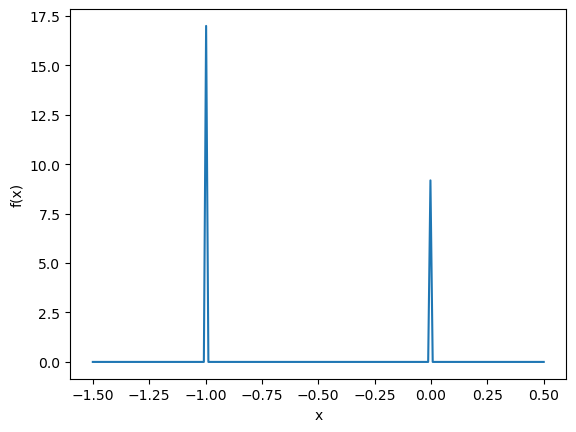

In [169]:
# Set-up.
n = 10000
np.random.seed(0x5eed)
# Parameters of the mixture components
norm_params = np.array([[var/(var+var_1/M)*sample_mean, var_1/(M+var_1/var)],
                        [var/(var+var_1/M)*(sample_mean-a), var_1/(M+var_1/var)]])
n_components = norm_params.shape[0]
# Weight of each component
alfa = 1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )
weights = [alfa, 1-alfa]

# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(-1.5, 0.5, 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(norm_params, weights):
    ys += st.norm.pdf(xs, loc=l, scale=s) * w

plt.plot(xs, ys)
#plt.hist(y, bins="fd")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [213]:
label = 'eps = %s'%(eps[1])
label

'eps = 0.25'

In [219]:
len(eps)

4